# Example of reading LENS data with xarray and many cheyenne workers

This notebook reads some data from the Large Ensemble (stored on glade)

## Step 1: Set up dask

Dask provides the backend for parallelizing computations being done on ensemble members. Users should copy `some file` to `~/.config/dask/jobqueue.yaml` to set default configuration settings that are well-suited to cheyenne.

In [1]:
import dask
import time
import xarray as xr

from dask.distributed import Client
from dask_jobqueue import PBSCluster

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
# I intentionally did not put a project number in jobqueue.yaml to make it easier to share
# Default queue is regular, but I am using premium because I am impatient
# Default walltime is 30 minutes
cluster = PBSCluster(queue='premium', project='P93300606')
client = Client(cluster)

client

Client Scheduler: tcp://10.148.10.13:38822 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Launch workers

Each worker is a process, and jobqueue.yaml is specifying a process as 4 cores (1/9 of a node). Therefore, if you request `9*N` workers, then `N` single-node jobs will be submitted to the queue; work will be spread among available workers.

In [2]:
cluster.scale(9*5)

## Step 2: set up matplotlib for nice inline plots

In [3]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Open LENS data set

User should specify variable name, frequency, and compset. For the first example, we are looking at monthly SST data.

In [4]:
TAVG_FREQ='monthly'
VAR='SST'
COMPSET='B20TRC5CNBDRD'

ds = xr.open_mfdataset(f"/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/{TAVG_FREQ}/{VAR}/b.e11.{COMPSET}*.nc", 
                       concat_dim="ensemble", chunks={"time": 120}, decode_times=False)

In [5]:
%%time

SST_mean = ds['SST'].mean('ensemble')
SST_mean_loc = SST_mean.isel(time=0,z_t=0).load()

# Make sure TLONG and TLAT are still coordinates
for coord in ["TLONG", "TLAT"]:
    if coord not in SST_mean_loc.coords:
        print(f"Adding {coord} to coordinate list")
        SST_mean_loc.coords[coord]=ds[coord].isel(ensemble=0)

print(SST_mean_loc)

Adding TLONG to coordinate list
<xarray.DataArray 'SST' (nlat: 384, nlon: 320)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [-1.682088, -1.675136, -1.669053, ...,       nan,       nan,       nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
    time     float64 6.753e+05
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    z_t      float32 500.0
    TLAT     (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    TLONG    (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
Dimensio

CPU times: user 2.84 s, sys: 4.02 s, total: 6.86 s
Wall time: 3.08 s


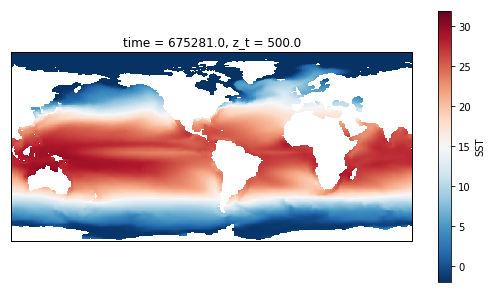

In [6]:
%%time

plt.figure(figsize=(9,5));
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=280));
SST_mean_loc.plot.pcolormesh(ax=ax, x='TLONG', y='TLAT', transform=ccrs.PlateCarree(), vmin=-2, vmax=32, cmap='RdBu_r')